In [1]:
# Let's collect some tools for this job...
import keras
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import SVG

Using TensorFlow backend.


In [2]:
# General parameters
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 100

In [3]:
# Generator
# Input layers setup [one for noise and one for class label]
noise = keras.layers.Input(shape=(latent_dim,))
label = keras.layers.Input(shape=(1,), dtype='int32')
label_embedding = keras.layers.Flatten()(keras.layers.Embedding(num_classes, 100)(label))
generator_input = keras.layers.multiply([noise, label_embedding])
# Generation of hidden layer structures
generator_hidden = keras.layers.Dense(128 * 7 * 7, activation='relu', input_dim=latent_dim)(generator_input)
generator_hidden = keras.layers.Reshape((7, 7, 128))(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2, activation='relu')(generator_hidden)
#generator_hidden = keras.layers.UpSampling2D()(generator_hidden)
#generator_hidden = keras.layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2, activation='relu')(generator_hidden)
#generator_hidden = keras.layers.UpSampling2D()(generator_hidden)
#generator_hidden = keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
g_image = keras.layers.Conv2DTranspose(channels, kernel_size=3, padding='same', activation='tanh')(generator_hidden)
# Finalize the model
generator = keras.Model([noise, label], g_image)
generator.compile(loss=['binary_crossentropy'],optimizer=keras.optimizers.Adam(0.0002,0.5))

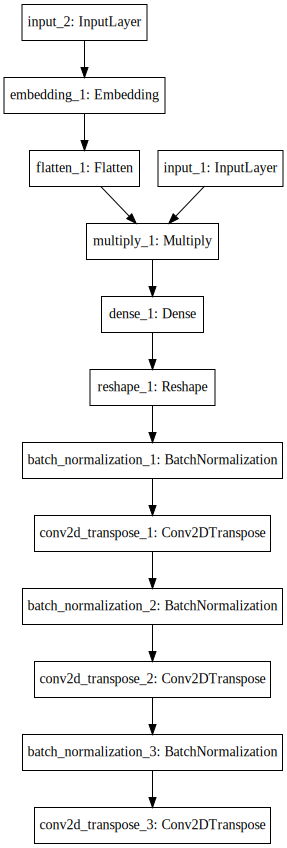

In [4]:
# Generator model structure
SVG(model_to_dot(generator).create(prog='dot', format='svg'))

In [6]:
# Discriminator
# Input for discriminator model is an image...
d_image = keras.layers.Input(shape=img_shape)
# Hidden layers
discriminator_hidden = keras.layers.Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding='same')(d_image)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.BatchNormalization(momentum=0.8)(discriminator_hidden)
discriminator_hidden = keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(discriminator_hidden)
discriminator_hidden = keras.layers.LeakyReLU(alpha=0.2)(discriminator_hidden)
discriminator_hidden = keras.layers.Dropout(0.25)(discriminator_hidden)
discriminator_hidden = keras.layers.Flatten()(discriminator_hidden)
# Outputs will be both a probability of being "real" and...
valid = keras.layers.Dense(1, activation='sigmoid')(discriminator_hidden)
# An probability of what class (with fakes having a unique class)
target_label = keras.layers.Dense(num_classes+1, activation='softmax')(discriminator_hidden)
# Finalize the model
discriminator = keras.Model(d_image, [valid, target_label])
discriminator.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'],
optimizer=keras.optimizers.Adam(0.0002,0.5),
metrics=['accuracy'])

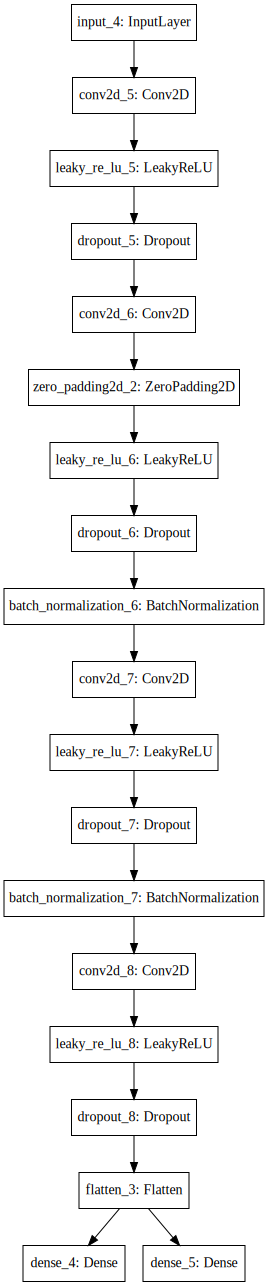

In [7]:
# Discriminator architecture
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

In [9]:
# Combined model...
# When training the generator, we need to pass through the discriminator...
# However, we don't want the discriminator to update during training
# of the generator (which would generate a -moving target- problem
# similar to RL agents)
# So, we will turn the discriminator training -off- when training with
# the combined model (combined model is really -only- used to train
# the generator even though it shares layers with the "trainable"
# discriminator that we made earlier)
# Turn off learning for generator...
discriminator.trainable = False
# Make the output of the generator feed into the discriminator.
# Note that we don't recompile the discriminator when doing this so that
# the discriminator can still be trained independently...
valid, target_label = discriminator(g_image) # g_image = generator output layer
# Combined model now takes generator inputs and has discriminator outputs...
combined = keras.Model([noise,label],[valid,target_label])
combined.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'],
                        optimizer=keras.optimizers.Adam(0.0002,0.5))

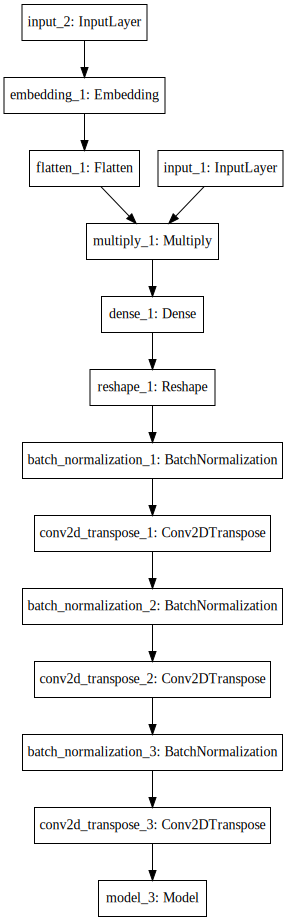

In [10]:
# Combined architecture - note that the discriminator part is not trainable!
SVG(model_to_dot(combined).create(prog='dot', format='svg'))

In [11]:
# Load image data - MNIST
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000, 1)


In [12]:
# Training Parameters
history = [[],[],[],[]]
batch_size = 32
half_batch_size = int(batch_size/2)

In [14]:
# Perform some number of epochs...
epochs = 10
# We need to perform this manually since the
# training is broken into phases for each
# component but still needs to be interleaved...
for epoch in range(epochs):
    # Training the discriminator...
    # Select half of the images for the discriminator from
    # the MNIST data set...
    idx = np.random.randint(0, X_train.shape[0], half_batch_size)
    real_images = X_train[idx]
    # Generate some Gaussian noise (random) 100-element vectors
    # to provide as inputs for the generator to make some "fakes"
    noise = np.random.normal(0, 1, (half_batch_size, 100))
    # We want those random vectors to be associated with a class...
    # That is, we are asking the generator to make these numbers...
    sampled_labels = np.random.randint(0, 10, half_batch_size).reshape(-1, 1)
    # Use the generator to make these images now!
    generated_images = generator.predict([noise, sampled_labels])
    # Generate the real-fake target distinctions
    # Reals are 1.0 (100% real)
    # Fakes are 0.0 (0% real)
    valid = np.ones((half_batch_size, 1))
    fake = np.zeros((half_batch_size, 1))
    # Use the labeled classes for the real images...
    image_labels = y_train[idx]
        # Assign the fake images to the "extra class" or "fake class"
    # on the one-hot encoding for all fake images (they are
    # not any of the digits 0-9 since they are -fakes- so
    # we don't used the requested generator labels...)
    fake_labels = 10 * np.ones(half_batch_size).reshape(-1, 1)
    # Train the discriminator - Two groups
    d_loss_real = discriminator.train_on_batch(real_images, [valid, image_labels])
    d_loss_fake = discriminator.train_on_batch(generated_images, [fake, fake_labels])
    # Calculate the average for an "overall" loss/accuracy for the discriminator...
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # Training the generator...
    # Make some noise!
    noise = np.random.normal(0, 1, (batch_size, 100))
    # Note that we are using the combined model to backprop the
    # loss to the generator... we therefore need to make some targets...
    # Call these real images! - we are trying to "fake-out" the
    # discriminator, so how would we accomplish this? Set the target
    # -as-if- the generated images were -real-!
    valid = np.ones((batch_size, 1))
    # Give them some labels so the generator can learn which digit
    # it is trying to fake.
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])
    # Add new results to history for plotting later...
    history[0] += [d_loss[0]]
    history[1] += [d_loss[3]]
    history[2] += [d_loss[4]]
    history[3] += [g_loss[0]]
    # Print progress indicator
    print("\r%d [Discriminator Loss: %f, Real/Fake-Acc.: %.2f%%, Classification-Acc: %.2f%%] [Generator Loss: %f]" % (
                                                epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]),end='')

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9 [Discriminator Loss: 2.804974, Real/Fake-Acc.: 50.00%, Classification-Acc: 43.75%] [Generator Loss: 3.829856]

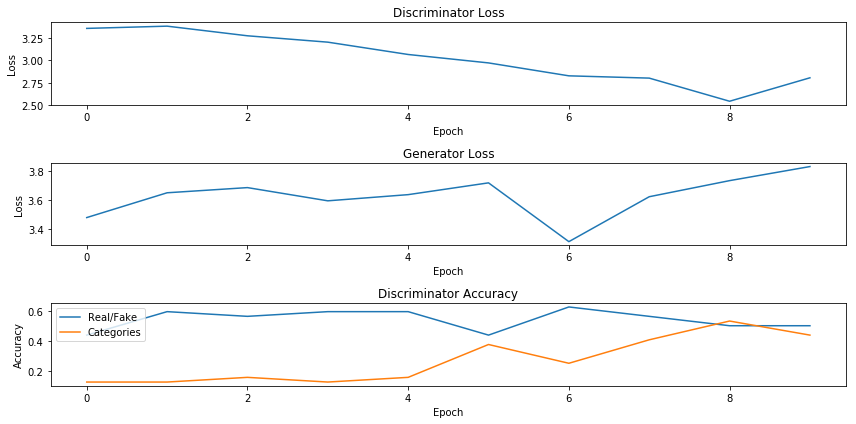

In [15]:
# Plot training history...
plt.figure(1,figsize=(12,6))
plt.subplot(311)
plt.plot(history[0])
plt.title('Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(312)
plt.plot(history[3])
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(313)
plt.plot(history[1])
plt.plot(history[2])
plt.title('Discriminator Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Real/Fake', 'Categories'], loc='upper left')
plt.tight_layout()
plt.show()

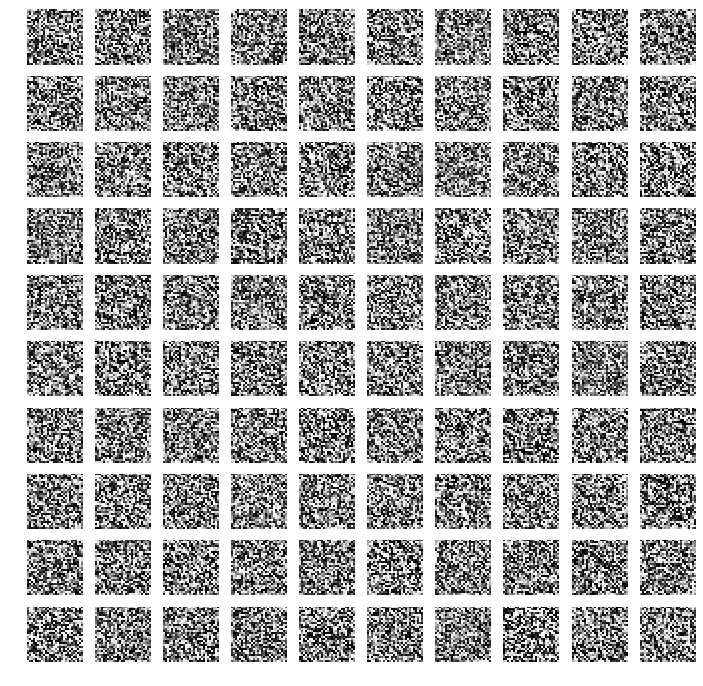

In [17]:
## Testing
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, 100))
sampled_labels = np.array([num for _ in range(r) for num in range(c)])
# Make some fakes!
generated_images = generator.predict([noise, sampled_labels])
# Rescale images 0 - 1
generated_images = 0.5 * generated_images + 1
# Plot them...
fig, axs = plt.subplots(r, c)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(generated_images[count, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        count += 1
plt.show()